In [ ]:
#importing necessary libraries 
import pandas as pd
import nltk
import gensim
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from gensim.parsing.preprocessing import STOPWORDS
import numpy as np
import pickle
nltk.download('stopwords')
nltk.download('wordnet')
from typing import List, Dict, Tuple, Set
import itertools
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pickle
import requests
import json
import urllib.request
import time
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
import re
from sklearn.metrics.pairwise import cosine_similarity
import statistics
from datetime import datetime
from scipy.stats import skew
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Reading dataset

In [ ]:
#importing the CSV file of the dataset from google drive into a dataframe
train_eclipse_df=pd.read_csv('drive/MyDrive/Project 6308 + ICSME/Siamese/Mobile_siamese_train_preprocessed.csv')
train_eclipse_df

,Unnamed: 0,description1,description2,is_similar
0,0,this way we can hold the placeholder color a...,the quick work around in bug didn t quite ...,0
1,1,having two build targets for this takes doub...,filed by btara at mozilla com job id ...,0
2,2,we are adding a feature now to focus klar to...,now that the user can browse documents in ...,0
3,3,user agent mozilla gecko firefox ...,user agent mozilla gecko firefox ...,1
4,4,created attachment png build device ...,right now we have to use intents which is c...,0
...,...,...,...,...
3818,4221,starting on x highlights will be removed a...,there are few additional events that we want...,0
3819,4223,user agent mozilla gecko firefox ...,this currently fails due to some raciness wi...,0
3820,4224,the mobile performance team thinks having ma...,created attachment screen shot at ...,0
3821,4225,final copy here ready for localization goal...,from github to bugzilla issues this...,0


In [ ]:
#importing the CSV file of the dataset from google drive into a dataframe
test_eclipse_df=pd.read_csv('drive/MyDrive/Project 6308 + ICSME/Siamese/Mobile_siamese_test_preprocessed.csv')
test_eclipse_df

,Unnamed: 0,description1,description2,is_similar
0,0,to integrate the functionality of taking scr...,created attachment screen shot at ...,0
1,1,created attachment png master build ...,filed by cbrindusan at mozilla com jo...,0
2,2,sebastian reports that input type file d...,robin mentioned that i want to edit a url a...,0
3,3,visit and the page doesn t load unless you...,bug ran geckoview mochitest on opt builds...,0
4,4,geckoprocessmanager needs to support multi...,created attachment user agent mozilla ...,0
...,...,...,...,...
954,1058,user agent mozilla applewebkit ...,created attachment user agent mozilla ...,0
955,1059,i just updated to sierra and updated xcode...,central as beta simulation how to ru...,0
956,1060,created attachment broken sites after fix ...,as part of the fission work we need to migra...,0
957,1062,there is a new option when long pressing on ...,we enabled browser tabs remote autostart in ...,0


In [ ]:
#Merge train & test
frames = [train_eclipse_df, test_eclipse_df]
result = pd.concat(frames)
result = result.sample(frac=1, random_state=1).reset_index(drop=True)
result1 = result.copy()
dup_df= result.copy()
dup_df

,Unnamed: 0,description1,description2,is_similar
0,1375,the following deep links are no longer worki...,filed by malexandru at mozilla com ...,0
1,3716,created attachment screen shot at ...,this is due to geckoviewhistory unconditiona...,0
2,2919,repeat performance of bug this time for g...,simion if you can help with qa ing this is...,0
3,3482,there have been a number of bugs false alar...,there have been a number of bugs false alar...,1
4,784,created attachment poc html user agent m...,this bug was initially created as a clon...,0
...,...,...,...,...
4777,3207,str visit a page you want to read like ...,build device ipad air ios pr...,0
4778,3067,initial module settings are no longer propag...,created attachment screen shot at ...,0
4779,1002,right now if you click a link with target b...,currently when building geckoview on macos ...,0
4780,182,geckoview example crashes on the youtube com...,if you scroll down slowly on a webpage the t...,0


In [ ]:
FEATURES = ['description1', 'description2']
print('Description of length of the feature columns')
dup_df[FEATURES].apply(lambda col: col.str.len().describe())

Description of length of the feature columns


,description1,description2
count,4782.000000,4782.000000
mean,1045.613760,994.800502
std,2925.653641,2696.171659
min,50.000000,50.000000
25%,176.000000,176.000000
50%,324.000000,320.000000
75%,583.000000,578.000000
max,40577.000000,40577.000000


## Train, Validation, Test Split

In [ ]:
from sklearn.model_selection import train_test_split
import random
import sklearn

In [ ]:
train_val_df = train_eclipse_df.copy()
train_val_df

,Unnamed: 0,description1,description2,is_similar
0,0,this way we can hold the placeholder color a...,the quick work around in bug didn t quite ...,0
1,1,having two build targets for this takes doub...,filed by btara at mozilla com job id ...,0
2,2,we are adding a feature now to focus klar to...,now that the user can browse documents in ...,0
3,3,user agent mozilla gecko firefox ...,user agent mozilla gecko firefox ...,1
4,4,created attachment png build device ...,right now we have to use intents which is c...,0
...,...,...,...,...
3818,4221,starting on x highlights will be removed a...,there are few additional events that we want...,0
3819,4223,user agent mozilla gecko firefox ...,this currently fails due to some raciness wi...,0
3820,4224,the mobile performance team thinks having ma...,created attachment screen shot at ...,0
3821,4225,final copy here ready for localization goal...,from github to bugzilla issues this...,0


In [ ]:
 test_df = test_eclipse_df.copy()
 test_df

,Unnamed: 0,description1,description2,is_similar
0,0,to integrate the functionality of taking scr...,created attachment screen shot at ...,0
1,1,created attachment png master build ...,filed by cbrindusan at mozilla com jo...,0
2,2,sebastian reports that input type file d...,robin mentioned that i want to edit a url a...,0
3,3,visit and the page doesn t load unless you...,bug ran geckoview mochitest on opt builds...,0
4,4,geckoprocessmanager needs to support multi...,created attachment user agent mozilla ...,0
...,...,...,...,...
954,1058,user agent mozilla applewebkit ...,created attachment user agent mozilla ...,0
955,1059,i just updated to sierra and updated xcode...,central as beta simulation how to ru...,0
956,1060,created attachment broken sites after fix ...,as part of the fission work we need to migra...,0
957,1062,there is a new option when long pressing on ...,we enabled browser tabs remote autostart in ...,0


In [ ]:
train_df, val_df = train_test_split(
  train_val_df,
  test_size=0.2,
  stratify=train_val_df.is_similar,
  random_state=13,
)

In [ ]:
train_df

,Unnamed: 0,description1,description2,is_similar
154,166,scenario i have an app with multiple tabs a...,build device ipad air ios ...,0
90,99,we see valid urls being rejected due to uns...,for some reason i thought we already did tha...,0
2460,2727,str load signed badssl com in fenix ...,str load signed badssl com in fenix ...,1
714,787,this should use production autopush servers ...,created attachment hardcore wrap png see ...,0
1638,1818,following investigation of bug we ved fou...,filed by cbrindusan at mozilla com jo...,0
...,...,...,...,...
2652,2942,older versions of the sentry dependency pull...,upgrade to is happening in bug ver...,0
2265,2514,this bug is for crash report bp ...,there are two tests suites that only apply f...,0
2590,2871,the highlights section does not seem to upda...,filed by nbeleuzu at mozilla com job ...,0
3104,3445,when syncing open tabs from an ios device to...,master iphone plus sign into sync ...,0


In [ ]:
val_df

,Unnamed: 0,description1,description2,is_similar
2526,2800,this bug was initially created as a clon...,follow up to bug areas of potential perfo...,0
3146,3497,filed by nbeleuzu at mozilla com pa...,we have implemented telemetry dashboards tha...,0
2046,2271,compared to chrome beta we load tripadvis...,str switch close private tabs on exit to o...,0
1375,1528,created attachment google cookies png use...,i see recent sentry crash reports from ...,0
2937,3255,this bug was filed from the socorro interfac...,created attachment mov user agent mozi...,0
...,...,...,...,...
2599,2881,just a request from my friend current br...,filed by malexandru at mozilla com ...,0
3233,3590,filed by opoprus at mozilla com par...,filed by opoprus at mozilla com par...,1
15,15,this will enable apps to be able to read the...,this will enable apps to be able to read the...,1
378,410,we are missing this in unifiedtelemetry wher...,diskimagestore is used to store screenshots ...,0


In [ ]:
print(f'Train Val Test Size: {len(train_df):,} {len(val_df):,} {len(test_df):,}')

Train Val Test Size: 3,058 765 959


## Download & Prepare Embedding

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf
import tensorflow.keras.utils as kutils
from keras.layers.preprocessing.text_vectorization import TextVectorization

In [ ]:
pip install kutils==0.3.0

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf
import tensorflow.keras.utils as kutils
from keras.layers.preprocessing.text_vectorization import TextVectorization

In [ ]:
from pathlib import Path
Path('C:\Program Files').parent

PosixPath('.')

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-04-08 04:39:09--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-04-08 04:39:09--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-04-08 04:39:09--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [ ]:
!unzip glove*.zip


Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.50d.txt        y

replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: glove.6B.100d.txt       y
y

replace glove.6B.200d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: glove.6B.200d.txt       y
y
y
y

replace glove.6B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: glove.6B.300d.txt       y
y



In [ ]:
!ls
!pwd

drive		   glove.6B.300d.txt  glove.6B.zip.1
glove.6B.100d.txt  glove.6B.50d.txt   model.png
glove.6B.200d.txt  glove.6B.zip       sample_data
/content


In [ ]:
import numpy as np
print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [ ]:
!pip install --upgrade pip
!pip install -U -q pydrive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null

!apt-get -y install -qq google-drive-ocamlfuse fuse

from google.colab import auth
auth.authenticate_user()
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive

E: Package 'python-software-properties' has no installation candidate
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=None&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force


KeyboardInterrupt: ignored

In [ ]:
import pickle
pickle.dump({'embeddings_index' : embeddings_index } , open('drive/MyDrive/Project 6308 + ICSME/Siamese/glove.42B.300d.txt', 'wb'))

In [ ]:
file_path = open('drive/MyDrive/Project 6308 + ICSME/Siamese/glove.42B.300d.txt',  mode="r", encoding="utf-8")

In [ ]:
from io import open

In [ ]:
def ensure_glove_embedding(verbose=False):
  import pathlib
  # If this operation fails, print the parent-dir
  # go there, and extract the file




def load_glove(path, words=None):
    word_to_embedding = {open('drive/MyDrive/Project 6308 + ICSME/Siamese/glove.42B.300d.txt',  mode="r", encoding="utf-8")}

    with iopen(path, 'r') as stream:
        for n, line in enumerate(stream):
            if not isinstance(line, str):
                line = line.decode('utf-8')
            split_line = line.split(' ')
            word = split_line[0]

            if words is None or word in words:
                try:
                    word_to_embedding[word] = [float(f) for f in split_line[1:]]
                except ValueError:
                    logger.error('{}\t{}\t{}'.format(n, word, str(split_line)))

    return word_to_embedding 

glove_file_path = ensure_glove_embedding(verbose=True)

In [ ]:


import numpy as np
print('Indexing word vectors.')

embedding_index = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embedding_index))


Indexing word vectors.
Found 400000 word vectors.


## create vocabulary index

In [ ]:
from typing import List

In [ ]:
MAX_TOKENS = 20000
MAX_TITLE_LENGTH = 21
MAX_DESCRIPTION_LENGTH = 300
EMBEDDING_DIM = 100

In [ ]:
def build_vocab(sentences: List[str], sequence_length: int):
  vectorizer = TextVectorization(
    max_tokens=MAX_TOKENS - 2,
    output_sequence_length=sequence_length,
  )
  vectorizer.adapt(sentences)
  vocab = vectorizer.get_vocabulary()
  word_index = dict(zip(vocab, range(len(vocab))))

  return vectorizer, word_index

In [ ]:
dup_df

,Unnamed: 0,description1,description2,is_similar
0,1375,the following deep links are no longer worki...,filed by malexandru at mozilla com ...,0
1,3716,created attachment screen shot at ...,this is due to geckoviewhistory unconditiona...,0
2,2919,repeat performance of bug this time for g...,simion if you can help with qa ing this is...,0
3,3482,there have been a number of bugs false alar...,there have been a number of bugs false alar...,1
4,784,created attachment poc html user agent m...,this bug was initially created as a clon...,0
...,...,...,...,...
4777,3207,str visit a page you want to read like ...,build device ipad air ios pr...,0
4778,3067,initial module settings are no longer propag...,created attachment screen shot at ...,0
4779,1002,right now if you click a link with target b...,currently when building geckoview on macos ...,0
4780,182,geckoview example crashes on the youtube com...,if you scroll down slowly on a webpage the t...,0


In [ ]:
descr_vectorizer, descr_word_index = build_vocab(
  [dup_df.description1, dup_df.description2],
  MAX_DESCRIPTION_LENGTH,
)

print(
  'Most frequent description words:',
  list(itertools.islice(descr_word_index.keys(), 5)),
)

Most frequent description words: ['', '[UNK]', 'task', 'info', 'mozilla']


## Create Embedding Matrix

In [ ]:
def create_embedding_matrix(
  embeddings_index: Dict[str, np.ndarray],
  word_index: Dict[str, int],
  verbose=False,
):
  hits = 0
  misses = 0

  # prepare embedding matrix
  embedding_matrix = np.zeros((MAX_TOKENS, EMBEDDING_DIM))
  for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
      # Words not found in embedding index will be all-zeros.
      # This includes the representation for "padding" and "OOV"
      embedding_matrix[i] = embedding_vector
      hits += 1
    else:
      misses += 1

  if verbose:
    print('Embedding shape:', embedding_matrix.shape)
    print(f'Found {hits} words, missed {misses}.')

  return embedding_matrix

In [ ]:
print('Creating description embedding matrix:')
descr_embedding_matrix = create_embedding_matrix(
  embeddings_index, descr_word_index, True,
)

Creating description embedding matrix:
Embedding shape: (20000, 100)
Found 6871 words, missed 5538.


## Prepare Training Data

In [ ]:
def generate_batches(
  split_df: pd.DataFrame,
  batch_size=1024,
):
  steps_per_epoch = len(split_df) // batch_size
  while True:
    for i in range(steps_per_epoch):
      offset = i * batch_size
      till = offset + batch_size
      feature_batches = []
      for feature in FEATURES:
        vectorizer = title_vectorizer if feature.startswith('title') else descr_vectorizer
        feature_batch = vectorizer(
          split_df[feature][offset: till].to_numpy().reshape((-1, 1))
        ).numpy()
        feature_batches.append(feature_batch)


      target_batch = split_df.is_similar[offset: till].to_numpy()
      yield (
        feature_batches,
        target_batch,
      )

## Create Models

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import callbacks
from keras.initializers.initializers_v2 import Constant

In [ ]:
DescrEmbeddingLayer = layers.Embedding(
  input_dim=MAX_TOKENS,
  output_dim=EMBEDDING_DIM,
  embeddings_initializer=Constant(descr_embedding_matrix),
  trainable=False,
  name='DescrEmbeddingLayer',
)

def make_descr_layer(num, kernel_size=3, pool_size=2, strides=None):
  DescrConv1dLayer = layers.Conv1D(
    filters=32,
    kernel_size=kernel_size,
    activation='relu',
    name=f'DescrConv1dLayer{num}',
  )
  DescrMaxPool1dLayer = layers.MaxPool1D(
    pool_size=pool_size,
    strides=strides,
    name=f'DescrMaxPool1dLayer{num}',
  )
  return DescrConv1dLayer, DescrMaxPool1dLayer

DescrConv1dLayer1, DescrMaxPool1dLayer1 = make_descr_layer(1, pool_size=4)
DescrConv1dLayer2, DescrMaxPool1dLayer2 = make_descr_layer(2)

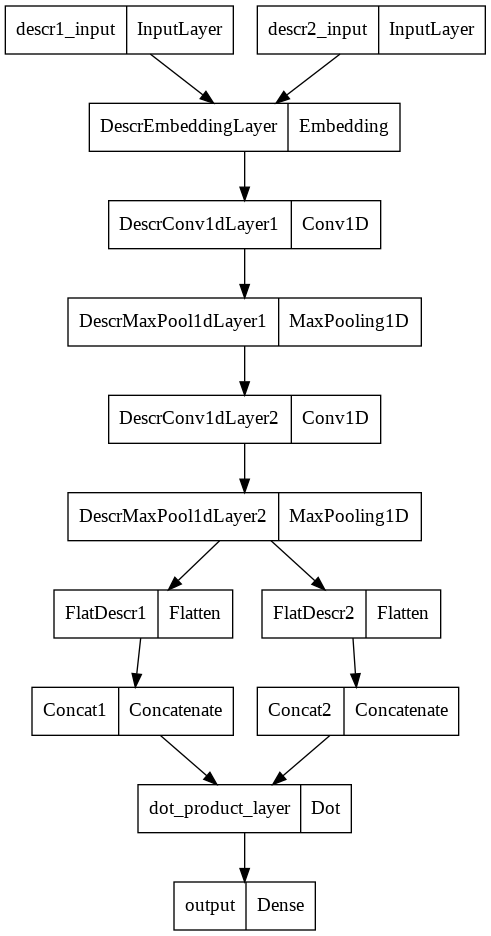

In [ ]:
def create_siamese_component(num: int):
  class SiameseComponent:
    def __init__(self, title: layers.Input, description: layers.Input, output: layers.Concatenate):
      self.title = title
      self.description = description
      self.output = output

  title_input = layers.Input(shape=(None,), dtype='int32', name=f'title{num}_input')

  descr_input = layers.Input(shape=(None,), name=f'descr{num}_input')
  descr_embedding_layer = DescrEmbeddingLayer(descr_input)
  descr_conv1d1 = DescrConv1dLayer1(descr_embedding_layer)
  descr_max_pool1d1 = DescrMaxPool1dLayer1(descr_conv1d1)
  descr_conv1d2 = DescrConv1dLayer2(descr_max_pool1d1)
  descr_max_pool1d2 = DescrMaxPool1dLayer2(descr_conv1d2)
  # descr_conv1d3 = DescrConv1dLayer3(descr_max_pool1d2)
  # descr_max_pool1d3 = DescrMaxPool1dLayer3(descr_conv1d3)
  descr_flat_Layer = layers.Flatten(name=f'FlatDescr{num}')(descr_max_pool1d2)
  
  concat = layers.Concatenate(axis=1, name=f'Concat{num}')([descr_flat_Layer])
  return SiameseComponent(title_input, descr_input, concat)


component1 = create_siamese_component(1)
component2 = create_siamese_component(2)

dot_product_layer = layers.Dot(
  axes=1,
  name='dot_product_layer'
)([component1.output, component2.output])
output = layers.Dense(
  1, activation='sigmoid', name='output',
)(dot_product_layer)
siamese_model = models.Model(
  inputs=[component1.description, component2.description],
  outputs=output,
  name='siamese_model'
)

kutils.plot_model(siamese_model)

## Train

In [ ]:
BATCH_SIZE = 256

siamese_model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['acc'],
)
callback = callbacks.ModelCheckpoint(
    filepath=f'../../drive/MyDrive/Project 6308 + ICSME/Siamese'
             '.epoch-{epoch:02d}-loss-{val_loss:.3f}.hdf5',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    mode='min',
)

In [ ]:
history = siamese_model.fit(
  generate_batches(train_df, BATCH_SIZE),
  steps_per_epoch=len(train_df) // BATCH_SIZE,
  epochs=150,
  validation_data=generate_batches(val_df, BATCH_SIZE),
  validation_steps=len(val_df) // BATCH_SIZE,
  verbose=1,
  # callbacks= [callback]
)

Epoch 1/150
11/11 [==============================] - 7s 578ms/step - loss: 0.0974 - acc: 0.9332 - val_loss: 1.0924 - val_acc: 0.9160
Epoch 2/150
11/11 [==============================] - 5s 419ms/step - loss: 0.0981 - acc: 0.9354 - val_loss: 1.0604 - val_acc: 0.9180
Epoch 3/150
11/11 [==============================] - 5s 415ms/step - loss: 0.0977 - acc: 0.9371 - val_loss: 1.0129 - val_acc: 0.9160
Epoch 4/150
11/11 [==============================] - 5s 419ms/step - loss: 0.0965 - acc: 0.9379 - val_loss: 0.9797 - val_acc: 0.9102
Epoch 5/150
11/11 [==============================] - 5s 416ms/step - loss: 0.0948 - acc: 0.9389 - val_loss: 0.9449 - val_acc: 0.9102
Epoch 6/150
11/11 [==============================] - 5s 416ms/step - loss: 0.0929 - acc: 0.9411 - val_loss: 0.9236 - val_acc: 0.9062
Epoch 7/150
11/11 [==============================] - 5s 418ms/step - loss: 0.0914 - acc: 0.9425 - val_loss: 0.9152 - val_acc: 0.9043
Epoch 8/150
11/11 [==============================] - 5s 418ms/step - 

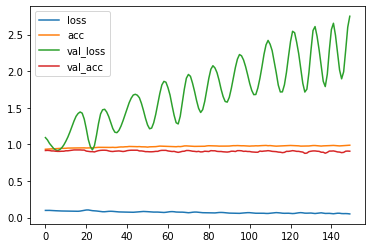

In [ ]:
ax = pd.DataFrame(history.history).plot()

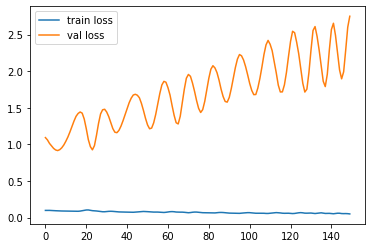

<Figure size 432x288 with 0 Axes>

In [ ]:
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot
import matplotlib.pyplot as plt
plot_model(siamese_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

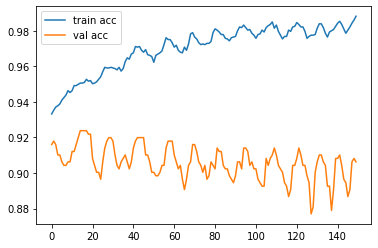

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the accuracy
from sklearn.metrics import accuracy_score
plt.plot(history.history['acc'], label='train acc')
plt.plot(history.history['val_acc'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

## Evaluate on test data

In [ ]:
# from tensorflow.keras.models import load_model

# siamese_model = load_model('../../models/siamese-openOffice.epoch-30-loss-0.457.hdf5')

In [ ]:
siamese_model.evaluate(
  generate_batches(test_df, BATCH_SIZE),
  steps=len(test_df) // BATCH_SIZE,
)

3/3 [==============================] - 0s 139ms/step - loss: 0.4175 - acc: 0.9362


[0.4175497591495514, 0.9361979365348816]

In [ ]:
len(test_df)

959

In [ ]:
BATCH_SIZE = len(test_df)
num_batched_instances = len(test_df) - (len(test_df) % BATCH_SIZE)
pred_y = siamese_model.predict(
  generate_batches(test_df, BATCH_SIZE),
  steps=len(test_df) // BATCH_SIZE,
  verbose=1,
)

1/1 [==============================] - 1s 723ms/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(
  test_df.is_similar[:num_batched_instances],
  pred_y > .5,
))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       906
           1       0.50      0.21      0.29        53

    accuracy                           0.94       959
   macro avg       0.73      0.60      0.63       959
weighted avg       0.93      0.94      0.93       959



In [ ]:
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,roc_auc_score
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics

In [ ]:
from sklearn.metrics import roc_curve

value_names = ['TPR', 'FPR', 'Threshold']
roc = dict(zip(value_names, roc_curve(
  test_df.is_similar[:num_batched_instances],
  pred_y,
)))
pd.DataFrame(roc)

,TPR,FPR,Threshold
0,0.000000,0.000000,1.733659e+00
1,0.000000,0.018868,7.336592e-01
2,0.002208,0.018868,6.839663e-01
3,0.002208,0.094340,6.573361e-01
4,0.003311,0.094340,6.432376e-01
...,...,...,...
77,0.864238,0.981132,1.015166e-16
78,0.940397,0.981132,5.106294e-23
79,0.940397,1.000000,5.034901e-23
80,0.991170,1.000000,2.345184e-37


In [ ]:
from sklearn.metrics import roc_auc_score

auroc = roc_auc_score(
  test_df.is_similar[:num_batched_instances],
  pred_y,
)

print('AUROC score:', auroc)

AUROC score: 0.8480153275854888


In [ ]:
print('For probability:')
print(f'Mean: {pred_y.mean()}, STD: {pred_y.std()}')
print('For categorical:')
print(f'Mean: {(pred_y > .5).mean()}, STD: {(pred_y > .5).std()}')

For probability:
Mean: 0.03196461871266365, STD: 0.10824401676654816
For categorical:
Mean: 0.022940563086548488, STD: 0.14971403959489096


## Evaluate on textually similar data

In [ ]:
#importing the CSV file of the dataset from google drive into a dataframe
sim_df=pd.read_csv('drive/MyDrive/Project 6308 + ICSME/Siamese/Mobile_siamese_textually_similar_test_duplicates_preprocessed.csv')
sim_df

,Unnamed: 0,description1,description2,is_similar
0,0,created attachment png user agent mozi...,filed by nerli at mozilla com parse...,0
1,1,seen on fenix mobile fenix issues a ...,user agent mozilla gecko firefox ...,0
2,2,java lang exception data is null at ...,str reported on fenix issue tracker mobil...,1
3,3,created attachment video demonstrating the...,filed by malexandru at mozilla com ...,0
4,4,filed by apavel at mozilla com pars...,filed by malexandru at mozilla com ...,1
...,...,...,...,...
67,94,filed by dvarga at mozilla com pars...,filed by nbeleuzu at mozilla com pa...,0
68,95,build master device ipad air ios ...,build master device ipad air ios ...,0
69,97,crash report stats mozilla org report ind...,filed by aklotz at mozilla com pars...,0
70,98,this bug continues a conversation from the o...,as part of the webextension support in bug ...,1


In [ ]:
len(sim_df)

72

In [ ]:
BATCH_SIZE = len(sim_df)
num_batched_instances = len(sim_df) - (len(sim_df) % BATCH_SIZE)
pred_y_sim = siamese_model.predict(
  generate_batches(sim_df, BATCH_SIZE),
  steps=len(sim_df) // BATCH_SIZE,
  verbose=1,
)

1/1 [==============================] - 0s 71ms/step


In [ ]:
siamese_model.evaluate(
  generate_batches(sim_df, BATCH_SIZE),
  steps=len(sim_df) // BATCH_SIZE,
)

1/1 [==============================] - 0s 94ms/step - loss: 4.7136 - acc: 0.7222


[4.713576793670654, 0.7222222089767456]

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
  sim_df.is_similar[:num_batched_instances],
  pred_y_sim > .5,
))

              precision    recall  f1-score   support

           0       0.72      1.00      0.84        51
           1       1.00      0.05      0.09        21

    accuracy                           0.72        72
   macro avg       0.86      0.52      0.46        72
weighted avg       0.80      0.72      0.62        72



In [ ]:
from sklearn.metrics import roc_curve

value_names = ['TPR', 'FPR', 'Threshold']
roc = dict(zip(value_names, roc_curve(
  sim_df.is_similar[:num_batched_instances],
  pred_y_sim,
)))
pd.DataFrame(roc)

,TPR,FPR,Threshold
0,0.000000,0.000000,1.632945e+00
1,0.000000,0.047619,6.329447e-01
2,0.000000,0.380952,1.956325e-01
3,0.156863,0.380952,1.923794e-02
4,0.156863,0.428571,1.843542e-02
5,0.274510,0.428571,1.088649e-03
6,0.274510,0.476190,6.228089e-04
7,0.294118,0.476190,5.683601e-04
8,0.294118,0.523810,4.580915e-04
9,0.333333,0.523810,1.518726e-04


In [ ]:
from sklearn.metrics import roc_auc_score

auroc = roc_auc_score(
  sim_df.is_similar[:num_batched_instances],
  pred_y_sim,
)

print('AUROC score:', auroc)


AUROC score: 0.6395891690009338


In [ ]:
print('For probability:')
print(f'Mean: {pred_y_sim.mean()}, STD: {pred_y_sim.std()}')
print('For categorical:')
print(f'Mean: {(pred_y_sim > .5).mean()}, STD: {(pred_y_sim > .5).std()}')

For probability:
Mean: 0.0480118989944458, STD: 0.12450630962848663
For categorical:
Mean: 0.013888888888888888, STD: 0.11702985796078277


## Evaluate on textually dissimilar data

In [ ]:
#importing the CSV file of the dataset from google drive into a dataframe
dissim_df=pd.read_csv('drive/MyDrive/Project 6308 + ICSME/Siamese/Mobile_siamese_textually_dissimilar_test_duplicates_preprocessed.csv')
dissim_df

,Unnamed: 0,description1,description2,is_similar
0,0,user agent mozilla applewebkit ...,created attachment screen shot at ...,0
1,2,we should investigate what s the story for p...,currently the gv autocomplete api only supp...,1
2,3,str start geckoview example from settin...,it isn t clear how this currently works ...,0
3,4,this bug was initially created as a clon...,user agent mozilla applewebkit ...,1
4,5,see this comment for details mobile firef...,url is form validation input id choo...,0
...,...,...,...,...
71,95,sometimes when typing in a textbox on nightl...,provide a user to have anywhere from t...,0
72,96,the brief crash report thread name thre...,this crash is happening in firefox for ios ...,1
73,99,lets support the new password autofill spec ...,currently geckoview s progressdelegate does ...,0
74,100,we had this crash in fxr stats mozilla or...,geckoresult allow is sometimes created on ...,1


In [ ]:
BATCH_SIZE = len(dissim_df)
num_batched_instances = len(dissim_df) - (len(dissim_df) % BATCH_SIZE)
pred_y_dis = siamese_model.predict(
  generate_batches(dissim_df, BATCH_SIZE),
  steps=len(dissim_df) // BATCH_SIZE,
  verbose=1,
)

1/1 [==============================] - 0s 77ms/step


In [ ]:
siamese_model.evaluate(
  generate_batches(dissim_df, BATCH_SIZE),
  steps=len(dissim_df) // BATCH_SIZE,
)

1/1 [==============================] - 0s 88ms/step - loss: 6.4802 - acc: 0.5789


[6.4801788330078125, 0.5789473652839661]

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
  dissim_df.is_similar[:num_batched_instances],
  pred_y_dis > .5,
))

              precision    recall  f1-score   support

           0       0.57      1.00      0.72        42
           1       1.00      0.06      0.11        34

    accuracy                           0.58        76
   macro avg       0.78      0.53      0.42        76
weighted avg       0.76      0.58      0.45        76



In [ ]:
from sklearn.metrics import roc_curve

value_names = ['TPR', 'FPR', 'Threshold']
roc = dict(zip(value_names, roc_curve(
  dissim_df.is_similar[:num_batched_instances],
  pred_y_dis,
)))
pd.DataFrame(roc)

,TPR,FPR,Threshold
0,0.000000,0.000000,1.719027e+00
1,0.000000,0.029412,7.190269e-01
2,0.000000,0.058824,5.621479e-01
3,0.047619,0.058824,3.369563e-01
4,0.047619,0.176471,2.047366e-01
5,0.071429,0.176471,1.849064e-01
6,0.071429,0.235294,1.239245e-01
7,0.095238,0.235294,1.066876e-01
8,0.095238,0.264706,9.974697e-02
9,0.119048,0.264706,5.994853e-02


In [ ]:
from sklearn.metrics import roc_auc_score

auroc = roc_auc_score(
  dissim_df.is_similar[:num_batched_instances],
  pred_y_dis,
)

print('AUROC score:', auroc)


AUROC score: 0.6099439775910365


In [ ]:
print('For probability:')
print(f'Mean: {pred_y_dis.mean()}, STD: {pred_y_dis.std()}')
print('For categorical:')
print(f'Mean: {(pred_y_dis > .5).mean()}, STD: {(pred_y_dis > .5).std()}')

For probability:
Mean: 0.05241191014647484, STD: 0.12990832328796387
For categorical:
Mean: 0.02631578947368421, STD: 0.16007269816574263
